<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/Customising_TensorFlow2_models/Neural_translation/Neural_translation_English_German.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions. Feel free to add extra cells into the notebook as required.

### How to submit

When you have completed the Capstone project notebook, you will submit a pdf of the notebook for peer review. First ensure that the notebook has been fully executed from beginning to end, and all of the cell outputs are visible. This is important, as the grading rubric depends on the reviewer being able to view the outputs of your notebook. Save the notebook as a pdf (you could download the notebook with File -> Download .ipynb, open the notebook locally, and then File -> Download as -> PDF via LaTeX), and then submit this pdf for review.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
import os
import numpy as np
from time import time

import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Layer, Concatenate, Input, Masking, LSTM, \
    Embedding, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy
from tensorflow.train import Checkpoint, latest_checkpoint

![Flags overview image](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/germany_uk_flags.png?raw=1")

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in local drive for use in this Colab notebook.

In [2]:
os.makedirs("./data", exist_ok=True)
os.makedirs("./cookie", exist_ok=True)

In [3]:
%%bash

fileid="1KczOciG7sYY7SB9UlBeRP1T9659b121Q"
filename="./data/deu.txt"
curl -c ./cookie -s -L "https://drive.google.com/uc?export=download&id=${fileid}" > /dev/null
curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=`awk '/download/ {print $NF}' ./cookie`&id=${fileid}" -o ${filename}

awk: read error (Is a directory)
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    232      0 --:--:--  0:00:01 --:--:--   232
100 29.9M    0 29.9M    0     0  14.2M      0 --:--:--  0:00:02 --:--:-- 14.2M


In [4]:
# Run this cell to load the dataset

NUM_EXAMPLES = 2000000
data_examples = []
with open('data/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [5]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) 
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

![Model Schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model.png?raw=1)

Key:
![Model key](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_key.png?raw=1")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A `<start>` token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [6]:
def create_sentence(data):
    """
    Preprocess the data using the preprocess_sentence function
    and return sentence pairs.
    """
    sentence_pair = [[preprocess_sentence(w) for w in l.split('\t')][:2] 
        for l in data]
    return zip(*sentence_pair)

# get pairs
en_sentence, ge_sentence = create_sentence(data_examples)
# show last 5 pairs
for pair in zip(en_sentence[-5:], ge_sentence[-5:]):
    print(pair)

("even if some sentences by non native speakers are good , it's really hard to trust that they are good , so members would be helping us much more by limiting their contributions to sentences in their own native languages .", 'auch wenn saetze von nichtmuttersprachlern mitunter durchaus gut sind , kann man sich doch schwer darauf verlassen . eine groessere hilfe ist es daher , wenn man sich darauf beschraenkt , saetze in seiner muttersprache beizutragen .')
("if someone who doesn't know your background says that you sound like a native speaker , it means they probably noticed something about your speaking that made them realize you weren't a native speaker . in other words , you don't really sound like a native speaker .", 'wenn jemand , der deine herkunft nicht kennt , sagt , dass du wie ein muttersprachler sprichst , bedeutet das , dass man wahrscheinlich etwas an deiner sprechweise bemerkt hat , das erkennen liess , dass du kein muttersprachler bist . mit anderen worten , du hoerst 

In [7]:
def add_start_end(sentence):
    """
    Adding a start and end token to the sentence so that the
    model know when to start and stop predicting.
    """
    return ["<start> " + s + " <end>" for s in sentence]

ge_sentence_start_end = add_start_end(ge_sentence)
# Print last 5 results
for sentence in ge_sentence_start_end[-5:]:
    print(sentence)

<start> auch wenn saetze von nichtmuttersprachlern mitunter durchaus gut sind , kann man sich doch schwer darauf verlassen . eine groessere hilfe ist es daher , wenn man sich darauf beschraenkt , saetze in seiner muttersprache beizutragen . <end>
<start> wenn jemand , der deine herkunft nicht kennt , sagt , dass du wie ein muttersprachler sprichst , bedeutet das , dass man wahrscheinlich etwas an deiner sprechweise bemerkt hat , das erkennen liess , dass du kein muttersprachler bist . mit anderen worten , du hoerst dich nicht wirklich wie ein muttersprachler an . <end>
<start> wenn jemand fremdes dir sagt , dass du dich wie ein muttersprachler anhoerst , bedeutet das wahrscheinlich er hat etwas an deinem sprechen bemerkt , dass dich als nicht muttersprachler verraten hat . mit anderen worten du hoerst dich nicht wirklich wie ein muttersprachler an . <end>
<start> es ist wohl unmoeglich , einen vollkommen fehlerfreien korpus zu erreichen das liegt in der natur eines solchen gemeinschaft

In [8]:
def create_tokenizer(sentence):
    """
    Create and return a Tokenizer.
    """
    tokenizer = Tokenizer(filters='')
    tokenizer.fit_on_texts(sentence)
    return tokenizer

# Build the German tokenizer vocabulary
ge_tokenizer = create_tokenizer(ge_sentence_start_end)
# Tokenize the German sentences
ge_sequence = ge_tokenizer.texts_to_sequences(ge_sentence_start_end)
# Print last 5 results
for sequence in ge_sequence[-5:]:
    print(sequence)

[1, 167, 63, 2571, 43, 33704, 9292, 4151, 74, 41, 4, 40, 90, 27, 188, 288, 353, 472, 3, 34, 2381, 220, 9, 14, 1676, 4, 63, 90, 27, 353, 11286, 4, 2571, 19, 218, 2335, 9634, 3, 2]
[1, 63, 249, 4, 17, 114, 8088, 8, 504, 4, 207, 4, 20, 12, 30, 21, 1954, 1197, 4, 1027, 11, 4, 20, 90, 525, 62, 38, 400, 10908, 1719, 18, 4, 11, 1769, 444, 4, 20, 12, 123, 1954, 69, 3, 28, 341, 4180, 4, 12, 1433, 50, 8, 152, 30, 21, 1954, 38, 3, 2]
[1, 63, 249, 13701, 52, 207, 4, 20, 12, 50, 30, 21, 1954, 10912, 4, 1027, 11, 525, 16, 18, 62, 38, 549, 168, 1719, 4, 20, 50, 49, 8, 1954, 1233, 18, 3, 28, 341, 4180, 12, 1433, 50, 8, 152, 30, 21, 1954, 38, 3, 2]
[1, 14, 9, 270, 1015, 4, 42, 1419, 33705, 33706, 13, 983, 11, 431, 19, 17, 2301, 366, 1570, 33707, 3, 188, 63, 22, 322, 3297, 299, 403, 98, 4, 8, 28, 713, 33708, 4, 15, 10, 133, 228, 4, 926, 2571, 19, 372, 1023, 2335, 9634, 4, 361, 4560, 14, 60, 216, 4, 15, 2325, 17, 276, 784, 13, 457, 3, 2]
[1, 203, 1407, 898, 27, 29, 136, 365, 13, 1008, 191, 349, 15, 883, 

In [9]:
# Randomly select 5 examples of English and German sentence pairs
num_samples = 5
inx = np.random.choice(len(en_sentence), num_samples, replace=False)

for n, i in enumerate(inx):
    print(n, en_sentence[i])
    print(n, ge_sentence_start_end[i], ge_sequence[i])

0 it isn't always easy to do that .
0 <start> das faellt einem nicht immer leicht . <end> [1, 11, 729, 110, 8, 81, 409, 3, 2]
1 i like to play with words .
1 <start> ich spiele gern mit woertern . <end> [1, 5, 961, 232, 28, 12323, 3, 2]
2 did you tell tom when to come ?
2 <start> haben sie tom gesagt , wann er kommen soll ? <end> [1, 39, 10, 6, 132, 4, 169, 16, 149, 213, 7, 2]
3 are you going to use that ?
3 <start> wirst du das benutzen ? <end> [1, 227, 12, 11, 728, 7, 2]
4 i thought that you were going to wait for me .
4 <start> ich dachte , ihr wuerdet auf mich warten . <end> [1, 5, 217, 4, 36, 1575, 29, 31, 268, 3, 2]


In [10]:
def post_pad(sequence):
    """
    Pad each sequence to a maximum length.
    """
    return pad_sequences(sequence, padding='post')

ge_padded = post_pad(ge_sequence)
# Print last 5 results
for sequence in ge_padded[-5:]:
    print(sequence)

[    1   167    63  2571    43 33704  9292  4151    74    41     4    40
    90    27   188   288   353   472     3    34  2381   220     9    14
  1676     4    63    90    27   353 11286     4  2571    19   218  2335
  9634     3     2     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[    1    63   249     4    17   114  8088     8   504     4   207     4
    20    12    30    21  1954  1197     4  1027    11     4    20    90
   525    62    38   400 10908  1719    18     4    11  1769   444     4
    20    12   123  1954    69     3    28   341  4180     4    12  1433
    50     8   152    30    21  1954    38     3     2     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0 

## 2. Prepare the data with tf.data.Dataset objects

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** This model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [11]:
# Load embedding module from Tensorflow Hub
embed_dim=128
embedding_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
    output_shape=(embed_dim), input_shape=(), dtype=tf.string)

In [12]:
# Test the layer

embedding_layer(tf.constant(
    ["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [13]:
# Create a random training and validation sets using an 80-20 split
en_train, en_valid, ge_train, ge_valid = train_test_split(
    en_sentence, ge_padded, test_size=0.2)

# Examine the shape of data
print("The shape of training dataset:")
print(f"English: {np.array(en_train).shape} \t German: {ge_train.shape}")
print("The shape of validation dataset:")
print(f"English: {np.array(en_valid).shape} \t German: {ge_valid.shape}")

The shape of training dataset:
English: (160415,) 	 German: (160415, 85)
The shape of validation dataset:
English: (40104,) 	 German: (40104, 85)


In [14]:
def create_dataset(inputs):
    """
    Take a tuple of inputs (source, label) 
    to create a tf.data.Dataset object.
    """
    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    dataset = dataset.shuffle(len(inputs[0]))
    return dataset

# Create Dataset object for both training and vailidation sets
train_dataset = create_dataset((en_train, ge_train))
valid_dataset = create_dataset((en_valid, ge_valid))

# # Print the first 5 elements of the training dataset
for x, y in train_dataset.take(5):
    print(x.numpy(), y.numpy())

b'i forget your phone number .' [   1    5 2452  402 1061    8    3    2    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
b"he succeeded to his uncle's fortune ." [    1    16    18    11 12430   660  8370 16985     3     2     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0  

In [15]:
def split_sentence(sentence):
    """
    Split each sentence at spaces.
    """
    return tf.strings.split(sentence, sep=' ')

# Map the function over the both dataset objects. 
train_dataset = train_dataset.map(lambda x, _: (split_sentence(x), _))
valid_dataset = valid_dataset.map(lambda x, _: (split_sentence(x), _))

# # Print the first 5 elements of English sentence from the training dataset
for x, _ in train_dataset.take(5):
    print(x.numpy())

[b'tom' b'said' b'mary' b'is' b'very' b'happy' b'.']
[b'he' b'does' b'twenty' b'push' b'ups' b'every' b'morning' b'.']
[b"i'm" b'anxious' b'to' b'see' b'you' b'.']
[b'we' b'have' b'seen' b'no' b'one' b'.']
[b'tom' b'clearly' b"doesn't" b'want' b'any' b'help' b'from' b'us' b'.']


In [16]:
def embed_word(sequence):
    """
    Embeds each sequence of word using the loaded embedding layer.
    """
    return embedding_layer(sequence)

# Map the function over the both dataset objects. 
train_dataset = train_dataset.map(lambda x, _: (embed_word(x), _))
valid_dataset = valid_dataset.map(lambda x, _: (embed_word(x), _))

# Print the number of element for both datasets
print("The number of element for training dataset: {}".format(
    train_dataset.cardinality().numpy()))
print("The number of element for validation dataset: {}".format(
    valid_dataset.cardinality().numpy()))

The number of element for training dataset: 160415
The number of element for validation dataset: 40104


In [17]:
def filter_token(sequence):
    """
    Filter dataset where the sequence length < 13 tokens.
    """
    return len(sequence)<13

# Filter over the both Dataset objects.
train_dataset = train_dataset.filter(lambda x, _: filter_token(x))
valid_dataset = valid_dataset.filter(lambda x, _: filter_token(x))

# Print the number of element for both datasets
print("The number of element for training dataset: {}".format(
    train_dataset.reduce(0, lambda x, _: x + 1).numpy()))
print("The number of element for validation dataset: {}".format(
    valid_dataset.reduce(0, lambda x, _: x + 1).numpy()))

The number of element for training dataset: 152605
The number of element for validation dataset: 38237


In [18]:
def pre_pad(sequence):
    """
    Pads each sequence with some distinct value before the sequence, 
    so that each sequence length=13.
    """
    pad_size = tf.math.maximum(0, 13 - tf.shape(sequence)[0])
    paddings = tf.concat(([[pad_size, 0]], [[0, 0]]), axis=0)
    padded = tf.pad(sequence, paddings, "CONSTANT")
    return tf.reshape(padded, (13, 128))

# Map the function over the both Dataset objects. 
train_dataset = train_dataset.map(lambda x, _: (pre_pad(x), _))
valid_dataset = valid_dataset.map(lambda x, _: (pre_pad(x), _))

# Print the element_spec property for both datasets
print("The element_spec property of training dataset: \n {}".format(
    train_dataset.element_spec))
print("The element_spec property of validation dataset: \n {}".format(
    valid_dataset.element_spec))

The element_spec property of training dataset: 
 (TensorSpec(shape=(13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(85,), dtype=tf.int32, name=None))
The element_spec property of validation dataset: 
 (TensorSpec(shape=(13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(85,), dtype=tf.int32, name=None))


In [19]:
def create_batch(dataset, batch_size):
  """
  Batch the dataset using the batch_size argument, and 
  setting drop_remainder to True.
  """
  return dataset.batch(batch_size, drop_remainder=True)

# Batch the both Datasets with a batch size of 16.
batch_size=16
train_dataset = create_batch(train_dataset, batch_size)
valid_dataset = create_batch(valid_dataset, batch_size)

# Print the element_spec property for both datasets
print("The element_spec property of training dataset: \n {}".format(
    train_dataset.element_spec))
print("The element_spec property of validation dataset: \n {}".format(
    valid_dataset.element_spec))

The element_spec property of training dataset: 
 (TensorSpec(shape=(16, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 85), dtype=tf.int32, name=None))
The element_spec property of validation dataset: 
 (TensorSpec(shape=(16, 13, 128), dtype=tf.float32, name=None), TensorSpec(shape=(16, 85), dtype=tf.int32, name=None))


In [20]:
# Print the shape of the English data from the training dataset
x_train_batch, _ = next(iter(train_dataset.take(1)))
print("The shape of English data from the training dataset: {}".format( 
    x_train_batch.shape))

# Print the German data from the validation dataset
_, y_valid_batch = next(iter(valid_dataset.take(1)))
print("The German data from the validation dataset: \n {}".format( 
    y_valid_batch.numpy()))

The shape of English data from the training dataset: (16, 13, 128)
The German data from the validation dataset: 
 [[   1   17  336 ...    0    0    0]
 [   1  393  112 ...    0    0    0]
 [   1    5  108 ...    0    0    0]
 ...
 [   1 1187  318 ...    0    0    0]
 [   1   69   12 ...    0    0    0]
 [   1    5  326 ...    0    0    0]]


## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

![Encoder schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_encoder.png?raw=1")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [21]:
# Create a custom layer to add a learned end token embedding 
# to the encoder model using Layer subclassing API 
# according to the above specification.

class EndToken(Layer):
    """
    Takes a batch of sequences from datasets, and adds 
    an embedded 'end' token to the end of each sequence.
    """
    def __init__(self, **kwargs):
        super(EndToken, self).__init__(**kwargs)
        self.end_token = tf.Variable(embedding_layer(
            tf.constant(['end'])), name='end_token')
        
    def call(self, inputs):
        x = tf.expand_dims(self.end_token, axis=0)
        x = tf.tile(x, (tf.shape(inputs)[0], 1, 1))
        return Concatenate(axis=1)([inputs, x])

# Instantiate the custom layer object
end_token_layer = EndToken()

In [22]:
# Extract a batch of English data from the training Dataset.
x_train_batch, _ = next(iter(train_dataset.take(1)))
# Print the shape before the custom layer
print("English tensor shape before the end_token_layer: {}".format( 
    x_train_batch.shape))

English tensor shape before the end_token_layer: (16, 13, 128)


In [23]:
# Test the custom layer on the English data and print the resulting shape
print("English tensor shape after the end_token_layer: {}".format( 
    end_token_layer(x_train_batch).shape))

English tensor shape after the end_token_layer: (16, 14, 128)


## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [24]:
# Build a RNN encoder model using the functional API
# according to the above specification.

# A batch of sequences of from dataset as input.
inputs = Input(shape=(None, embed_dim))
# Add end token embedding to the end of sequence using end_token_layer.
x = end_token_layer(inputs)
# Masking layer with the mask_value set to 0.0.
x = Masking(mask_value=0.0)(x)
# LSTM layer with 512 units returns hidden and cell states.
output, hidden_state, cell_state = LSTM(units=512, return_state=True)(x)

# Instantiate the RNN encoder model object.
encoder = Model(inputs=inputs, outputs=[hidden_state, cell_state])

In [25]:
# Extract a batch of English data from the training dataset.
x_train_batch, _ = next(iter(train_dataset.take(1)))

# Test the encoder model on the English data and print the resulting shape.
hidden_state, cell_state = encoder(x_train_batch)
print("The shape of Encoder hidden state (batch_size, units): {}".format( 
    hidden_state.shape))
print("The shape of Encoder cell state (batch_size, units): {}".format( 
    cell_state.shape))

The shape of Encoder hidden state (batch_size, units): (16, 512)
The shape of Encoder cell state (batch_size, units): (16, 512)


In [26]:
# Print the trainable variables
print("Trainable variables for the encoder model:")
for v in encoder.trainable_variables:
    print("Name: {}, shape: {}".format(v.name, v.shape))

Trainable variables for the encoder model:
Name: end_token:0, shape: (1, 128)
Name: lstm/lstm_cell/kernel:0, shape: (128, 2048)
Name: lstm/lstm_cell/recurrent_kernel:0, shape: (512, 2048)
Name: lstm/lstm_cell/bias:0, shape: (2048,)


In [27]:
# Print the model summary for the encoder model.
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
end_token (EndToken)         (None, None, 128)         128       
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below.

![Decoder schematic](https://github.com/MengOonLee/Deep_learning/blob/master/TensorFlow2/Tutorial/image/neural_translation/neural_translation_model_decoder.png?raw=1)

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [28]:
# Build an RNN decoder model using Model subclassing API
# according to the above specification.

class Decoder(Model):
    """
    Take a batch of data from dataset through Embedding layer. It is 
    followed by LSTM layer with initial state from the RNN encoder model. 
    The LSTM output is passed through Dense layer, which returns the 
    resulting output along with the LSTM hidden and cell states.
    """
    def __init__(self, **kwargs):
        super(Decoder, self).__init__(**kwargs)
        # Define layers
        # Embedding layer with vocabulay size=number of unique German tokens, 
        # 128 embedding dimension, and mask zero values is True.
        self.embedding = Embedding(input_dim=len(ge_tokenizer.word_index)+1, 
            output_dim=128, mask_zero=True)
        # LSTM layer with 512 units returns 
        # sequences, hidden and cell states.
        self.lstm = LSTM(units=512, return_state=True, return_sequences=True)
        # Dense layer with units=number of unique German tokens
        # and no activation function.
        self.dense = Dense(units=len(ge_tokenizer.word_index)+1, 
            activation=None)

    def call(self, inputs, hidden_state=None, cell_state=None):
        # Define forward pass
        x = self.embedding(inputs)
        x, hidden_state, cell_state = self.lstm(x, 
            initial_state=[hidden_state, cell_state])
        output = self.dense(x)
        return output, hidden_state, cell_state

# Instantiate the RNN decoder model object.
decoder = Decoder()

In [29]:
# Extract a batch of English and German data from the training dataset
x_train_batch, y_train_batch = next(iter(train_dataset.take(1)))

# First call the encoder model on the English data to get the 
# hidden and cell states
hidden_state, cell_state = encoder(x_train_batch)

# Then test the decoder model on the German data,
# using the hidden and cell states from the encoder model, 
# and print the shape of resulting outputs.
output, hidden_state, cell_state = decoder(y_train_batch, 
    hidden_state=hidden_state, cell_state=cell_state)
print("The shape of Decoder outputs (batch_size*seq_length, vocab_size): {}".format( 
    output.shape))
print("The shape of Decoder hidden state (batch_size, units): {}".format( 
    hidden_state.shape))
print("The shape of Decoder cell state (batch_size, units): {}".format( 
    cell_state.shape))

The shape of Decoder outputs (batch_size*seq_length, vocab_size): (16, 85, 33714)
The shape of Decoder hidden state (batch_size, units): (16, 512)
The shape of Decoder cell state (batch_size, units): (16, 512)


In [30]:
# Print the trainable variables
print("Trainable variables for the decoder model:")
for v in decoder.trainable_variables:
    print("Name: {}, shape: {}".format(v.name, v.shape))

Trainable variables for the decoder model:
Name: decoder/embedding/embeddings:0, shape: (33714, 128)
Name: decoder/lstm_1/lstm_cell_1/kernel:0, shape: (128, 2048)
Name: decoder/lstm_1/lstm_cell_1/recurrent_kernel:0, shape: (512, 2048)
Name: decoder/lstm_1/lstm_cell_1/bias:0, shape: (2048,)
Name: decoder/dense/kernel:0, shape: (512, 33714)
Name: decoder/dense/bias:0, shape: (33714,)


In [31]:
# Print the model summary for the decoder model.
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  4315392   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  1312768   
_________________________________________________________________
dense (Dense)                multiple                  17295282  
Total params: 22,923,442
Trainable params: 22,923,442
Non-trainable params: 0
_________________________________________________________________


## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [32]:
def create_input_target(sequence):
    """
    Take a sequence return a tuple of input and target.
    """
    return sequence[:, :-1], sequence[:, 1:]

# Extract a batch of German data from the training dataset.
_, y_train_batch = next(iter(train_dataset.take(1)))

# Create a tuple containing German input and output for the decoder model.
labels_input, labels_target = create_input_target(y_train_batch)
# Show the first 5 pairs
for x, y in zip(labels_input[:5], labels_target[:5]):
    print("Input: {} \n Output: {}".format(x, y))

Input: [    1    24    18     6    52    56 10507   429     7     2     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0] 
 Output: [   24    18     6    52    56 10507   429     7     2     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0   

In [33]:
# Define a categorical cross entropy loss object
loss_object = SparseCategoricalCrossentropy(from_logits=True)

# Define the encoder and decoder trainable variables
variables = encoder.trainable_variables \
    + decoder.trainable_variables

# Define a function to compute the forward and backward pass 
# for the translation model according to the above specification.
# Use the @tf.function decorator
@tf.function
def gradients(inputs, labels_input, labels_target):
    """
    Compute a loss and gradient of the encoder and decoder models, 
    corresponding to the encoder input, decoder input and decoder output.
    """
    with tf.GradientTape() as tape:
        # Pass inputs into the encoder to get hidden and cell states.
        hidden_state, cell_state = encoder(inputs)
        # Pass the hidden and cell states into the decoder, 
        # along with labels input to get prediction.
        prediction, _, _ = decoder(labels_input, 
            hidden_state=hidden_state, cell_state=cell_state)
        # Compute loss between the labels target and prediction
        loss = loss_object(labels_target, prediction)
    # Compute gradients with respect to the trainable variables
    gradient = tape.gradient(loss, variables)
    return loss, gradient, prediction

In [34]:
# Define and run a custom training loop for a number of epochs
# according to the above specification

# Define the Adam optimizer.
optimizer = Adam(learning_rate=0.001)

# Generate a checkpoint object.
checkpoint_dir = "./training_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = Checkpoint(optimizer=optimizer, 
    encoder=encoder, decoder=decoder)

# Create lists to accumulate the metric values
train_loss = []
train_accuracy = []
valid_loss = []
valid_accuracy = []
valid_loss_min = np.Inf

start_time = time()
num_epochs = 10
for epoch in range(num_epochs):
    # Compute training loss and accuracy on the training dataset
    train_batch_loss_avg = Mean()
    train_batch_accuracy = SparseCategoricalAccuracy()
    # Iterate through the training dataset
    for inputs, labels in train_dataset:
        # Create labels input and target from the labels
        labels_input, labels_target = create_input_target(labels)
        # Compute loss, gradient and prediction using 
        # the gradients function above
        loss, gradient, prediction = gradients(
            inputs, labels_input, labels_target)
        # Update the variables of the model using the optimizer object
        optimizer.apply_gradients(zip(gradient, variables))
        # Compute average train loss
        train_batch_loss_avg(loss)
        # Compute accuracy between labels_target and prediction
        train_batch_accuracy(labels_target, prediction)
        
    # Compute validation loss and accuracy on the validation dataset
    valid_batch_loss_avg = Mean()
    valid_batch_accuracy = SparseCategoricalAccuracy()
    for inputs, labels in valid_dataset:
        # Create labels input and target from the labels
        labels_input, labels_target = create_input_target(labels)
        # Pass inputs into the encoder to get hidden and cell states.
        hidden_state, cell_state = encoder(inputs)
        # Pass the hidden and cell states into the decoder, 
        # along with decoder input to get prediction.
        prediction, _, _ = decoder(labels_input, 
            hidden_state=hidden_state, cell_state=cell_state)
        # Compute loss between the labels target and prediction
        loss = loss_object(labels_target, prediction)
        # Compute average valid loss
        valid_batch_loss_avg(loss)
        # Compute accuracy between labels target and prediction
        valid_batch_accuracy(labels_target, prediction)
            
    # Return a list of losses values per epoch.
    train_epoch_loss = train_batch_loss_avg.result().numpy()
    train_epoch_accuracy = train_batch_accuracy.result().numpy()
    print("Epoch {:03d}: Train loss: {:.3f}, Train accuracy: {:.3f}".format(
        epoch, train_epoch_loss, train_epoch_accuracy))
    valid_epoch_loss = valid_batch_loss_avg.result().numpy()
    valid_epoch_accuracy = valid_batch_accuracy.result().numpy()
    print("Epoch {:03d}: Valid loss: {:.3f}, Valid accuracy: {:.3f}".format(
        epoch, valid_epoch_loss, valid_epoch_accuracy))
    
    # Save only the weights that generate the lowest validation loss.
    if valid_epoch_loss <= valid_loss_min:
        print("Validation loss decreased. Saving checkpoint")
        checkpoint.save(file_prefix=checkpoint_prefix)
        valid_loss_min = valid_epoch_loss
    
    # Save the training and validation losses and accuracy every epoch
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    valid_loss.append(valid_epoch_loss)
    valid_accuracy.append(valid_epoch_accuracy)

print("Duration :{:.3f}".format(time() - start_time))

Epoch 000: Train loss: 3.249, Train accuracy: 0.944
Epoch 000: Valid loss: 0.317, Valid accuracy: 0.955
Validation loss decreased. Saving checkpoint
Epoch 001: Train loss: 0.219, Train accuracy: 0.961
Epoch 001: Valid loss: 0.194, Valid accuracy: 0.964
Validation loss decreased. Saving checkpoint
Epoch 002: Train loss: 0.146, Train accuracy: 0.969
Epoch 002: Valid loss: 0.172, Valid accuracy: 0.967
Validation loss decreased. Saving checkpoint
Epoch 003: Train loss: 0.113, Train accuracy: 0.974
Epoch 003: Valid loss: 0.164, Valid accuracy: 0.969
Validation loss decreased. Saving checkpoint
Epoch 004: Train loss: 0.091, Train accuracy: 0.977
Epoch 004: Valid loss: 0.162, Valid accuracy: 0.970
Validation loss decreased. Saving checkpoint
Epoch 005: Train loss: 0.077, Train accuracy: 0.980
Epoch 005: Valid loss: 0.163, Valid accuracy: 0.970
Epoch 006: Train loss: 0.066, Train accuracy: 0.983
Epoch 006: Valid loss: 0.166, Valid accuracy: 0.970
Epoch 007: Train loss: 0.058, Train accuracy: 0

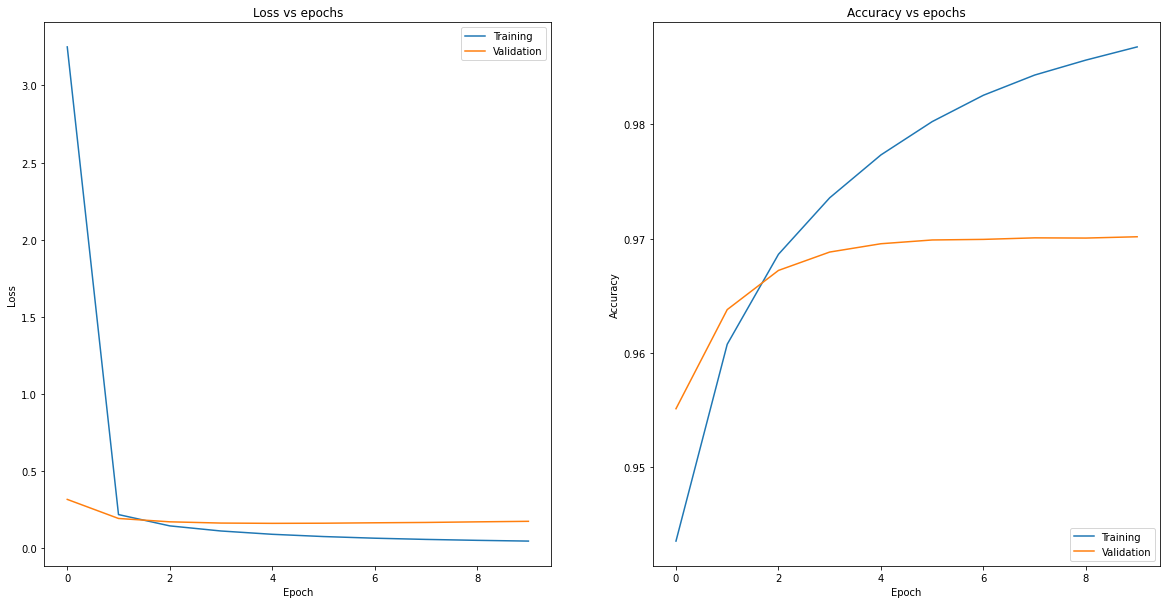

In [35]:
# Plot the learning curves for loss vs epoch and 
# accuracy vs epoch for both training and validation sets.
fig = plt.figure(figsize=(20, 10))
# Loss vs epoch
plt.subplot(121)
plt.plot(train_loss)
plt.plot(valid_loss)
plt.title("Loss vs epochs")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="upper right")

# Accuracy vs epoch
plt.subplot(122)
plt.plot(train_accuracy)
plt.plot(valid_accuracy)
plt.title("Accuracy vs epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Training", "Validation"], loc="lower right")
plt.show()

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

In [36]:
# Restore the checkpoint that saves only the weights that generate the 
# lowest validation loss in checkpoint_dir.
checkpoint.restore(latest_checkpoint('./training_checkpoints'))

In [37]:
# 5 randomly sampled of English sentences from the dataset
num_samples = 5
inx = np.random.choice(len(en_sentence), num_samples, replace=False)

for inputs, labels in zip(np.array(en_sentence)[inx], 
    np.array(ge_sentence)[inx]):
    # Preprocess and embed the inputs sentence 
    # according to the above requirement.
    x = split_sentence(inputs)
    x = embed_word(x)
    if filter_token(x):
        x = pre_pad(x)
    else:
        continue
    x = tf.expand_dims(x, axis=0)
    # Pass the embedded sentence through the encoder
    # to get hidden and cell states.
    hidden_state, cell_state = encoder(x)
    # Compute prediction result and accuracy
    predicts = ""
    accuracy = SparseCategoricalAccuracy()
    # Tokenize the labels sentence
    y = ge_tokenizer.texts_to_sequences([labels])
    y = pad_sequences(y, maxlen=ge_padded.shape[1], padding='post')
    # Starting with the special "<start>" token
    dec_input = tf.expand_dims([ge_tokenizer.word_index["<start>"]], 0)
    # Create a loop to get prediction, hidden and cell states
    # until reach a maximum length
    for t in range(ge_padded.shape[1]):
        prediction, hidden_state, cell_state = decoder(dec_input, 
            hidden_state=hidden_state, cell_state=cell_state)
        # Decode the output token sequence into German text
        predict_id = tf.argmax(tf.squeeze(prediction)).numpy()
        predict_word = ge_tokenizer.index_word[predict_id]
        # Terminate the loop when the "<end>" token in emitted
        if predict_word!="<end>":
            predicts += predict_word + " "
            dec_input = tf.expand_dims([predict_id], 0)
        else:
            break
        # Compute accuracy between labels and prediction
        accuracy(y[:, t], tf.squeeze(prediction))

    # Print the English, German texts and the predicted German translation
    print("Input: {}".format(inputs))
    print("True translation: {}".format(labels))
    print("Predict translation: {}".format(predicts))
    print("Accuracy: {}\n".format(accuracy.result().numpy()))

Input: tom can't remember when mary moved to boston .
True translation: tom kann sich nicht erinnern , wann mary nach boston gezogen ist .
Predict translation: tom kann sich nicht erinnern , wann maria nach boston gezogen ist . 
Accuracy: 0.9230769276618958

Input: tom is suspicious .
True translation: tom ist misstrauisch .
Predict translation: tom ist unzuverlaessig . 
Accuracy: 0.75

Input: tom stole my money .
True translation: tom hat mir mein geld gestohlen .
Predict translation: tom hat mir mein geld gestohlen . 
Accuracy: 1.0

Input: we took a long hike up to the summit .
True translation: wir unternahmen eine lange wanderung hoch zum gipfel .
Predict translation: wir haben uns eine lange zum letzten zug getroffen . 
Accuracy: 0.10000000149011612

Input: did you get a massage ?
True translation: hast du dir eine massage verpassen lassen ?
Predict translation: hast du ein bad bekommen ? 
Accuracy: 0.3333333432674408

